In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl

# Simulating Reaction-Diffusion Systems

In this notebook we want to show step by step how to simulate a reaction-diffusion system in Python. Here, we decided for the [Gray-Scott model](http://www.karlsims.com/rd.html) because of the variety of shapes it can produce.

In this models, we have two chemicals $A$ and $B$ which are distributed across a grid of size $N$. The symbol $A_{ij}$ represents the concentration of chemical $A$ at grid coordinates $(i,j)$ (similar for $B$).

The discrete reaction-diffusion update equations are 

$$
A_{ij}(t+1) = A_{ij}(t) + \Big[D_A (\nabla^2 A)_{ij} - A_{ij}B_{ij}^2 + f(1-A_{ij}) \Big]\times\Delta t\\
B_{ij}(t+1) = B_{ij}(t) + \Big[D_B (\nabla^2 B)_{ij} + A_{ij}B_{ij}^2 - (k+f)B_{ij} \Big]\times\Delta t
$$

The single terms are explained in the tutorial linked above.

First, we need to take care of the discretized Laplacian terms. 

## Discrete Laplacian
As explained on [Wikipedia](https://en.wikipedia.org/wiki/Discrete_Laplace_operator#Implementation_via_operator_discretization), the discretized Laplacian of a grid cell $(i,j)$ can be computed by summing over neighboring cells and subtract the value of the original cell with the total weight. One possible implementation is to only recognize direct neighbors of grid difference $\Delta=1$, i.e. at $(i,j-1)$, $(i,j+1)$, $(i-1,j)$, and $(i+1,j)$.

The whole update formula is

$$
(\nabla^2 A)_{ij} = A_{i,j-1} + A_{i,j+1} + A_{i-1,j} + A_{i+1,j} - 4A_{ij}
$$

How can we do this efficiently in `numpy`? Let's first define a small concentration matrix `A`.

In [2]:
A = np.ones((3,3))
A[1,1] = 0
A

array([[1., 1., 1.],
       [1., 0., 1.],
       [1., 1., 1.]])

Now for each cell, we want to add its right neighbor. We can easily access this value in a matrix sense by doing a `numpy.roll`, which shifts all elements in a certain direction, with periodic boundary conditions.

In [3]:
right_neighbor = np.roll(A, # the matrix to permute
                         (0,-1), # we want the right neighbor, so we shift the whole matrix -1 in the x-direction)
                         (0,1), # apply this in directions (y,x)
                        )
right_neighbor

array([[1., 1., 1.],
       [0., 1., 1.],
       [1., 1., 1.]])

So to compute the discrete Laplacian of a matrix $M$, one could use the following function.

In [4]:
def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return L

Let's test this with our example matrix

In [5]:
discrete_laplacian(A)

array([[ 0., -1.,  0.],
       [-1.,  4., -1.],
       [ 0., -1.,  0.]])

Seems like it worked! Note that periodic boundary conditions were used, too.

## Implement update formula

Computing the Laplacian was the hardest part. The other parts are simple. Just take the concentration matrices and apply the update formula.

In [6]:
def gray_scott_update(A, B, DA, DB, f, k, delta_t):
    """
    Updates a concentration configuration according to a Gray-Scott model
    with diffusion coefficients DA and DB, as well as feed rate f and
    kill rate k.
    """
    
    # Let's get the discrete Laplacians first
    LA = discrete_laplacian(A)
    LB = discrete_laplacian(B)
    
    # Now apply the update formula
    diff_A = (DA*LA - A*B**2 + f*(1-A)) * delta_t
    diff_B = (DB*LB + A*B**2 - (k+f)*B) * delta_t
    
    A += diff_A
    B += diff_B
    
    return A, B

## Choosing initial conditions

The initial conditions are very important in the Gray-Scott model. If you just randomize the initial conditions it might happen that everything just dies out. It seems to be a good idea to assume a homogeneous distribution of chemicals with a small disturbance which can then produce some patterns. We can also add a bit of noise. We can do the same decisions as Rajesh Singh in his [somewhat more elaborate version](https://rajeshrinet.github.io/blog/2016/gray-scott/) and disturb with a square in the center of the grid. Let's do the following.

In [7]:
def get_initial_configuration(N, random_influence=0.2):
    """
    Initialize a concentration configuration. N is the side length
    of the (N x N)-sized grid.
    `random_influence` describes how much noise is added.
    """
    
    # We start with a configuration where on every grid cell 
    # there's a lot of chemical A, so the concentration is high
    A = (1-random_influence) * np.ones((N,N)) + random_influence * np.random.random((N,N))
    
    # Let's assume there's only a bit of B everywhere
    B = random_influence * np.random.random((N,N))
    
    # Now let's add a disturbance in the center
    N2 = N//2
    radius = r = int(N/10.0)
    
    A[N2-r:N2+r, N2-r:N2+r] = 0.50
    B[N2-r:N2+r, N2-r:N2+r] = 0.25
    
    return A, B

Let's also add a function which makes nice drawings and then draw some initial configurations.

In [8]:
def draw(A,B):
    """draw the concentrations"""
    fig, ax = pl.subplots(1,2,figsize=(5.65,4))
    ax[0].imshow(A, cmap='Greys')
    ax[1].imshow(B, cmap='Greys')
    ax[0].set_title('A')
    ax[1].set_title('B')
    ax[0].axis('off')
    ax[1].axis('off')

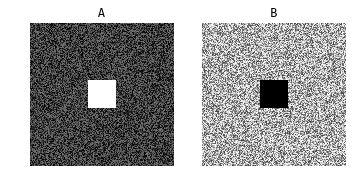

In [9]:
A, B = get_initial_configuration(200)
draw(A,B)

Now we can simulate! We should first decide for some parameter choices. Let's stick with  [Rajesh's choices](https://rajeshrinet.github.io/blog/2016/gray-scott/).

In [10]:
# update in time
delta_t = 1.0

# Diffusion coefficients
DA = 0.16
DB = 0.08

# define feed/kill rates
f = 0.060
k = 0.062

# grid size
N = 200

# simulation steps
N_simulation_steps = 10000

And for the simulation we simply update the concentrations for `N_simulation_steps` time steps.

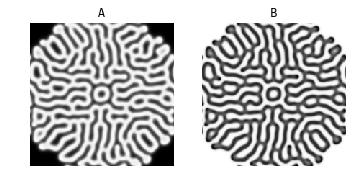

In [11]:
A, B = get_initial_configuration(200)

for t in range(N_simulation_steps):
    A, B = gray_scott_update(A, B, DA, DB, f, k, delta_t)
    
draw(A,B)

Isn't this nice? You might also want to try the following values (directly taken from Rajesh's version above):

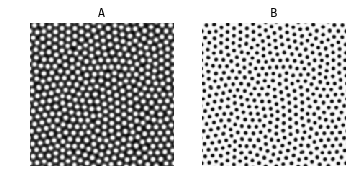

In [ ]:
DA, DB, f, k = 0.14, 0.06, 0.035, 0.065 # bacteria
A, B = get_initial_configuration(200)

for t in range(N_simulation_steps):
    A, B = gray_scott_update(A, B, DA, DB, f, k, delta_t)
    
draw(A,B)

## Animate

I personally think it's easier to understand systems when we see how they evolve over time. It's also prettier! So let's put `matplotlib`'s internal animation API to a use. First, we need to import the necessary libraries

In [ ]:
import matplotlib.animation as animation  # this is needed for the animation API
from matplotlib.colors import Normalize   # this is needed to rescale the color during the simulation

Now, we have to redefine the draw function such that it returns the matplotlib figure as well as the artists in which the concentrations are drawn.

In [ ]:
def get_artists(A,B):
    """draw the concentrations"""
    fig, ax = pl.subplots(1,2,figsize=(5.65,3))
    imA = ax[0].imshow(A, animated=True, cmap='Greys')
    imB = ax[1].imshow(B, animated=True, cmap='Greys')
    ax[0].set_title('A')
    ax[1].set_title('B')
    ax[0].axis('off')
    ax[1].axis('off')
    
    return fig, imA, imB

Furthermore, we have to define an update function which takes care of the update for each frame. The first argument of this function has to the frame id. The other arguments can be customized to whatever we need for the updates. Besides the parameters for the model, we will also add a variable that defines how many updates are done before the next frame is shown.

In [ ]:
def updatefig(frame_id,updates_per_frame,A,B,DA,DB,f,k,delta_t):
    """Takes care of the matplotlib-artist update in the animation"""
    global imA, imB

    # update x times before updating the frame
    for u in range(updates_per_frame):
        A, B = gray_scott_update(A,B,DA,DB,f,k,delta_t)

    # update the frame
    imA.set_array(A)
    imB.set_array(B)

    # renormalize the colors
    imA.set_norm(Normalize(vmin=np.amin(A),vmax=np.amax(A)))
    imB.set_norm(Normalize(vmin=np.amin(B),vmax=np.amax(B)))

    # return the updated matplotlib objects
    return imA, imB

Now we can animate! However, we also have to add a bit of matplotlib mambo-jumbo so we can view the animation in the notebook.

In [ ]:
# Diffusion coefficients
DA = 0.16
DB = 0.08

# define feed/kill rates
f = 0.060
k = 0.062

N_simulation_steps = 10000

# intialize the figures
A, B = get_initial_configuration(N)
fig, imA, imB = get_artists(A, B)

# how many updates should be computed before a new frame is drawn
updates_per_frame = 2

# these are the arguments which have to passed to the update function
animation_arguments = (updates_per_frame, A, B, DA, DB, f, k, delta_t)

# let's make sure we can see the animation in the notebook
from IPython.display import HTML
mpl.rcParams['animation.html'] = 'html5'
#mpl.rcParams['animation.embed_limit'] = 1024 # this allows jupyter notebook to save 1024MB video data in the memory


# start the animation
ani = animation.FuncAnimation(fig, #matplotlib figure
                              updatefig, # function that takes care of the update
                              fargs=animation_arguments, # arguments to pass to this function
                              interval=10, # update every `interval` milliseconds
                              frames=int(N_simulation_steps/updates_per_frame), #limit the number of frames
                              blit=True, # optimize the drawing update
                              )

HTML(ani.to_html5_video())

In [ ]:
As